# **San Francisco crime classification**

# **Needed to install cartopy in colab**


In [15]:
# !apt-get -qq install python-cartopy python3-cartopy
# !pip install geoplot

# **Import packages**

In [90]:
import os
import re
import shutil
import zipfile
import warnings
import numpy as np
import pandas as pd
import urllib.request
import xgboost as xgb
import seaborn as sns
# import geoplot as gplt
# import geopandas as gpd
# import contextily as ctx
import matplotlib as mpl
from matplotlib import cm
from sklearn.svm import SVC
from xgboost import XGBClassifier
from shapely.geometry import Point
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

warnings.filterwarnings("ignore")
%matplotlib inline

# **Download dataset from kaggle**

In [17]:
# from google.colab import files
# files.upload()
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c sf-crime

# **Load data**

In [18]:
train = pd.read_csv('/content/train.csv.zip', parse_dates=['Dates'])
test = pd.read_csv('/content/test.csv.zip', parse_dates=['Dates'], index_col='Id')
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (878049, 9)
Test shape: (884262, 6)


# **Data exploration**

In [19]:
print("-" * 15 + " Train " + "-" * 14)
print('First date: ', str(train['Dates'].describe()['first']))
print('Last date: ', str(train['Dates'].describe()['last']))
print('Data shape ', train.shape)
print("-" * 15 + " Test " + "-" * 15)
print('First date: ', str(test['Dates'].describe()['first']))
print('Last date: ', str(test['Dates'].describe()['last']))
print('Data shape ', test.shape)

--------------- Train --------------
First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00
Data shape  (878049, 9)
--------------- Test ---------------
First date:  2003-01-01 00:01:00
Last date:  2015-05-10 23:59:00
Data shape  (884262, 6)


In [20]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [21]:
test.head()

,Dates,DayOfWeek,PdDistrict,Address,X,Y
Id,,,,,,
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


# **Dataset includes the following variables**
*   Dates - timestamp of the crime incident
*   Category - category of the crime incident. (This is our target variable.)
*   Descript - detailed description of the crime incident
*   DayOfWeek - the day of the week
*   PdDistrict - the name of the Police Department District
*   Resolution - The resolution of the crime incident
*   Address - the approximate street address of the crime incident
*   X - Longitude
*   Y - Latitude

# **Unique values**

In [22]:
print("No. of category: {}".format(train['Category'].nunique()))
print("No. of Descript: {}".format(train['Descript'].nunique()))
print("No. of PdDistrict: {}".format(train['PdDistrict'].nunique()))
print("No. of Resolution: {}".format(train['Resolution'].nunique()))
print("No. of Resolution: {}".format(train['Address'].nunique()))

No. of category: 39
No. of Descript: 879
No. of PdDistrict: 10
No. of Resolution: 17
No. of Resolution: 23228


# **Train features data type**

In [23]:
train.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

# **Duplicated rows**

In [24]:
print("Duplicated rows: {}".format(train.duplicated().sum()))

Duplicated rows: 2323


# **Drop duplicated rows**

In [25]:
train.drop_duplicates(inplace=True)

# **Dates & Day of the week**

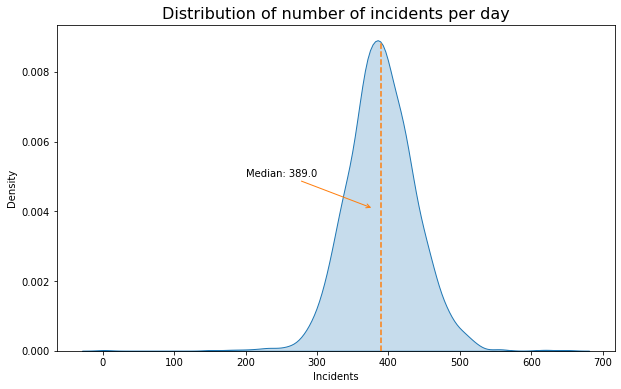

In [26]:
col = sns.color_palette()

train['Date'] = train['Dates'].dt.date

plt.figure(figsize=(10, 6))
data = train.groupby('Date').count().iloc[:, 0]
sns.kdeplot(data=data, shade=True)
plt.axvline(x=data.median(), ymax=0.95, linestyle='--', color=col[1])
plt.annotate(
    'Median: ' + str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))
plt.title(
    'Distribution of number of incidents per day', fontdict={'fontsize': 16}, color='black')
plt.xlabel('Incidents', color='black')
plt.ylabel('Density', color='black')
plt.xticks(color= 'black')
plt.yticks(color= 'black')
plt.show()

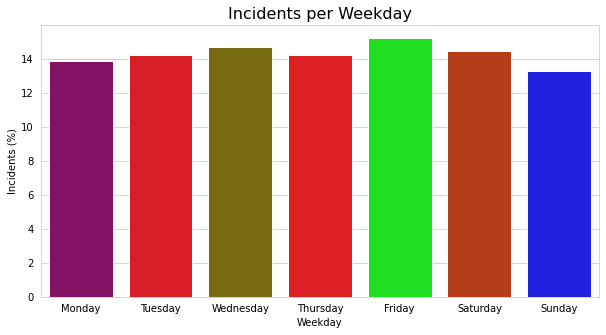

In [27]:
data = train.groupby('DayOfWeek').count().iloc[:, 0]
data = data.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
])

plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        data.index, (data.values / data.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='brg').to_rgba(data.values))

plt.title('Incidents per Weekday', fontdict={'fontsize': 16}, color= 'black')
plt.xlabel('Weekday', color= 'black')
plt.ylabel('Incidents (%)', color= 'black')
plt.xticks(color= 'black')
plt.yticks(color= 'black')
plt.show()

# **Category**

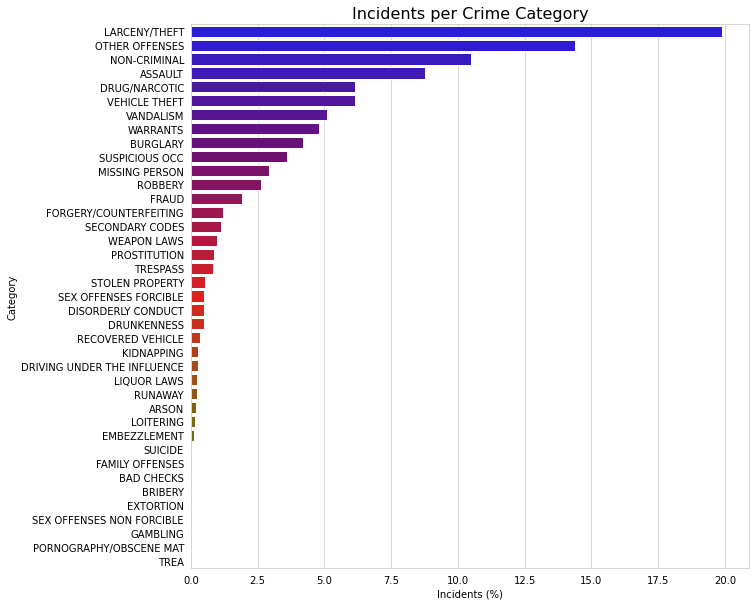

In [28]:
data = train.groupby('Category').count().iloc[:, 0]
data = data.reindex(train['Category'].unique())
data = data.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        (data.values / data.values.sum()) * 100,
        data.index,
        orient='h',
        palette="brg",)

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16}, color='black')
plt.xlabel('Incidents (%)', color='black')
plt.ylabel('Category', color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.show()

# **Police District**

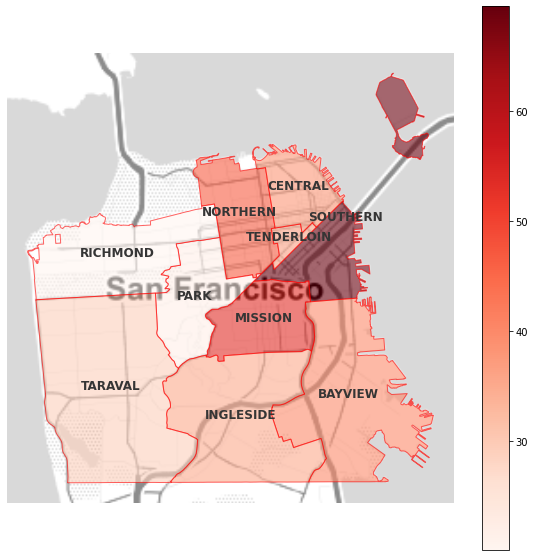

In [29]:
# Downloading the shapefile of the area 
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
# Unzipping it
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')
# Loading to a geopandas dataframe
for filename in os.listdir('./pd_data/'):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        break
# Defining the coordinate system to longitude/latitude
pd_districts.crs={'init': 'epsg:4326'}

# Merging our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    train.groupby('PdDistrict').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    how='inner',
    left_on='district',
    right_index=True,
    suffixes=('_x', '_y'))

# Transforming the coordinate system to Spherical Mercator for
# compatibility with the tiling background
pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})

# Calculating the incidents per day for every district
train_days = train.groupby('Date').count().shape[0]
pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

# Ploting the data
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()

# **X** - *Longitude* **Y** - *Latitude*

In [30]:
def create_gdf(df):
  gdf = df.copy()
  gdf['Coordinates'] = list(zip(gdf['X'], gdf['Y']))
  gdf['Coordinates'] = gdf['Coordinates'].apply(Point)
  gdf = gpd.GeoDataFrame(
      gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
  return gdf

# **Outlier coordinates**

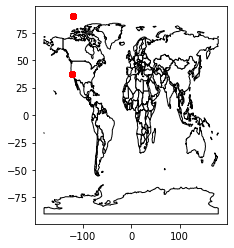

In [31]:
train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [ ]:
print(train_gdf.loc[train_gdf.Y > 50].count()[0])
# train_gdf.loc[train_gdf.Y > 50].sample(5)

# **Replace outlier coordinates**

In [33]:
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])

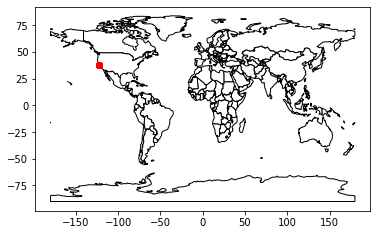

In [34]:
train_gdf = create_gdf(train)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

# **Geographic density of difference crimes**

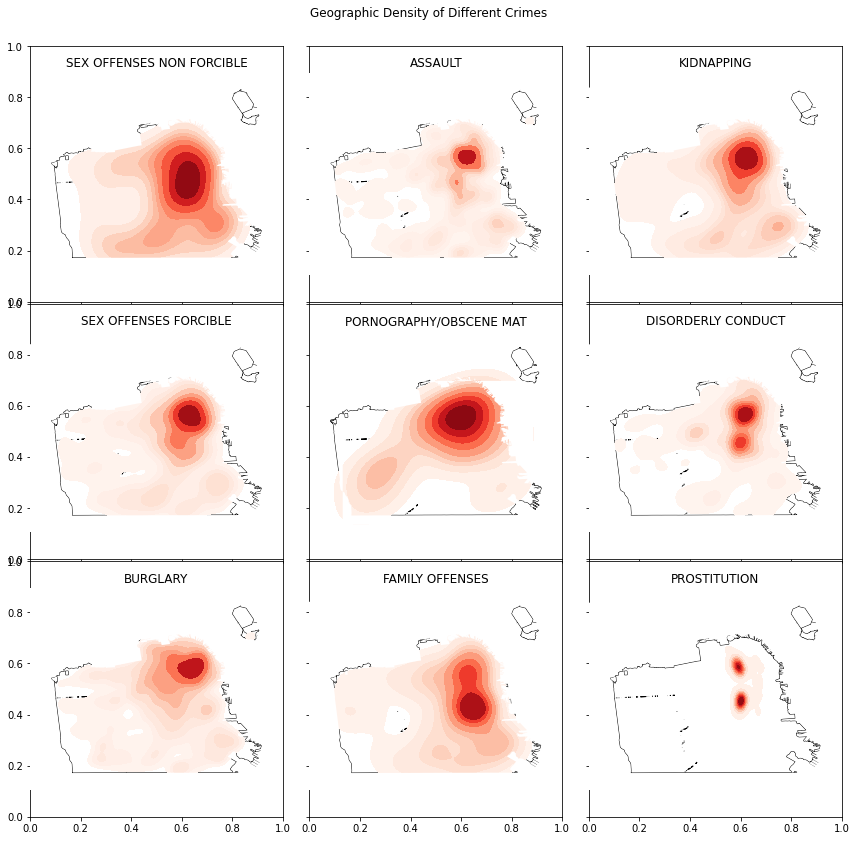

In [35]:
crimes = train['Category'].unique().tolist()

pd_districts = pd_districts.to_crs({'init':'epsg:4326'})
sf_land = pd_districts.unary_union
sf_land = gpd.GeoDataFrame(gpd.GeoSeries(sf_land), crs={'init':'epsg:4326'})
sf_land = sf_land.rename(columns={0:'geometry'}).set_geometry('geometry')

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))
for i , crime in enumerate(np.random.choice(crimes, size=9, replace=False)):
    data = train_gdf.loc[train_gdf['Category'] == crime]
    ax = fig.add_subplot(3, 3, i+1)
    gplt.kdeplot(data,
                 shade=True,
                 shade_lowest=False,
                 clip = sf_land.geometry,
                 cmap='Reds',
                 ax=ax)
    gplt.polyplot(sf_land, ax=ax)
    ax.set_title(crime) 
plt.suptitle('Geographic Density of Different Crimes')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Data Preprocessing**

In [36]:
train['Date'] = train['Dates'].dt.date

train['Day'] = train['Dates'].dt.day
train['Month'] = train['Dates'].dt.month
train['Year'] = train['Dates'].dt.year

train['Hour'] = train['Dates'].dt.hour
train['Minute'] = train['Dates'].dt.minute
train['Second'] = train['Dates'].dt.second

train['n_days'] = (train['Date'] - train['Date'].min()).apply(lambda x: x.days)

train['DayOfWeek'] = train['Dates'].dt.weekday

train['Block'] = train['Address'].str.contains('block', case=False)
train['ST'] = train['Address'].str.contains('ST', case=False)

train["X_Y"] = train["X"] - train["Y"]
train["XY"] = train["X"] + train["Y"]

In [37]:
test['Date'] = test['Dates'].dt.date

test['Day'] = test['Dates'].dt.day
test['Month'] = test['Dates'].dt.month
test['Year'] = test['Dates'].dt.year

test['Hour'] = test['Dates'].dt.hour
test['Minute'] = test['Dates'].dt.minute
test['Second'] = test['Dates'].dt.second

test['n_days'] = (test['Date'] - test['Date'].min()).apply(lambda x: x.days)

test['DayOfWeek'] = test['Dates'].dt.weekday

test['Block'] = test['Address'].str.contains('block', case=False)
test['ST'] = test['Address'].str.contains('ST', case=False)

test["X_Y"] = test["X"] - test["Y"]
test["XY"] = test["X"] + test["Y"]

# **average number of incidents per hour**

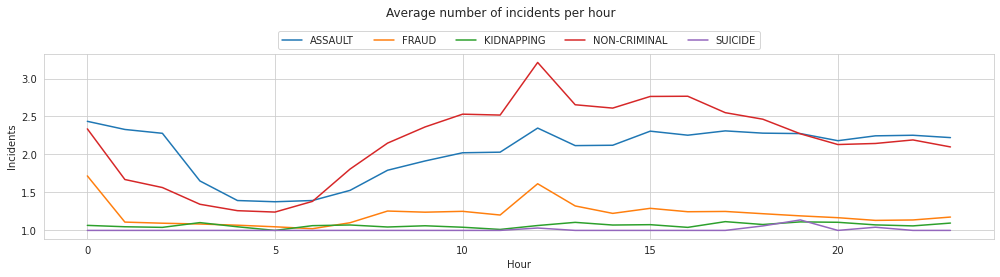

In [38]:
data = train.groupby(['Hour', 'Date', 'Category'], as_index=False).count().iloc[:, :4]
data.rename(columns={'Dates': 'Incidents'}, inplace=True)
data = data.groupby(['Hour', 'Category'], as_index=False).mean()

crimes = train['Category'].unique().tolist()
data = data.loc[data['Category'].isin(np.random.choice(crimes, size=5, replace=False))]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 4))
ax = sns.lineplot(x='Hour', y='Incidents', data=data, hue='Category')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6)
plt.suptitle('Average number of incidents per hour')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **PdDistrict encoding**

In [39]:
labelEncoderPdDistrict = LabelEncoder()

train['PdDistrict'] = labelEncoderPdDistrict.fit_transform(train['PdDistrict'])
test['PdDistrict'] = labelEncoderPdDistrict.transform(test['PdDistrict'])

# **Address encoding**

In [40]:
labelEncoderAdress = LabelEncoder()
labelEncoderAdress.fit(list(train['Address']) + list(test['Address']))

train['Address'] = labelEncoderAdress.transform(train['Address'])
test['Address'] = labelEncoderAdress.transform(test['Address'])

# **Category encoding**

In [41]:
labelEncoderCategory = LabelEncoder()

target = labelEncoderCategory.fit_transform(train['Category'])

# **Drop colums**

In [42]:
train.drop(['Dates','Date','Descript','Resolution', 'Category'], 1, inplace=True)

test.drop(['Dates','Date',], 1, inplace=True)

In [43]:
print("Train rows: {}".format(train.shape[0]))
print("-"*25)
print("Train columns: {}".format(train.shape[1]))
print("-"*25)
train.head(1)

Train rows: 875726
-------------------------
Train columns: 16
-------------------------


,DayOfWeek,PdDistrict,Address,X,Y,Day,Month,Year,Hour,Minute,Second,n_days,Block,ST,X_Y,XY
0,2,4,20895,-122.425892,37.774599,13,5,2015,23,53,0,4510,False,True,-160.20049,-84.651293


In [44]:
print("Test rows: {}".format(test.shape[0]))
print("-"*25)
print("Test columns: {}".format(test.shape[1]))
print("-"*25)
test.head(1)

Test rows: 884262
-------------------------
Test columns: 16
-------------------------


,DayOfWeek,PdDistrict,Address,X,Y,Day,Month,Year,Hour,Minute,Second,n_days,Block,ST,X_Y,XY
Id,,,,,,,,,,,,,,,,
0,6,0,6626,-122.399588,37.735051,10,5,2015,23,59,0,4512,True,False,-160.134639,-84.664537


# **Train, validation test split**

In [45]:
X_train, X_validation, y_train, y_validation = train_test_split(train, target, test_size=0.2, random_state=42)
X_test = test

# **Algorithms and Techniques**
| **Algorithm** | **Parameters** |                                            
| :-----------:   |   :----------: |
| Logistic regression  | penalty= 'l1', C= 1, solver= 'saga', multi_class= 'ovr', max_iter= 1 |
| Logistic regression  | penalty= 'l1', C= 1, solver= 'saga', multi_class= 'multinomial', max_iter= 1 |
| Logistic regression  | penalty= 'l2', C= 1, solver= 'lbfgs', multi_class= 'ovr', max_iter= 1 |
| Logistic regression  | penalty= 'l2', C= 1, solver= 'lbfgs, multi_class= 'multinomial', max_iter= 1 |
| SVC           | C= 1.0, gamma= 0.1, kernel= 'rbf', max_iter= 1, probability= True |
| Decision Tree | criterion= 'gini', max_depth= 3, random_state= 42 |
| Random Forest | n_estimators=1, criterion='gini', max_depth= 3, random_state=42 |
| AdaBoost      | base_estimator= None, n_estimators= 3|
| Gradient Boost | learning_rate= 0.1, n_estimators= 1, max_depth= 3, random_state= 42 |
| XGBoost       | n_estimators= 1, criterion= 'gini',learning_rate= 0.1, max_depth= 3 ,gamma= 10, reg_lambda= 1 , objective= 'multi:softmax', random_state= 42 |                    

# **LogisticRegression(penalty= 'l1', C= 1, solver= 'saga', multi_class= 'ovr', max_iter= 1)**

In [46]:
logisticRegressionModel = LogisticRegression(penalty= 'l1', C= 1, solver= 'saga', multi_class= 'ovr', max_iter= 1)
logisticRegressionModel.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
print("A list of class labels known to the classifier:\n{}\n".format(logisticRegressionModel.classes_))
print("Coefficient of the features:\n{}\n".format(logisticRegressionModel.coef_))
print("Intercept:\n{}\n".format(logisticRegressionModel.intercept_))
print("Maximum number of iterations taken for the solvers to converge:\n{}\n".format(logisticRegressionModel.n_iter_))

A list of class labels known to the classifier:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]

Coefficient of the features:
[[-4.60135220e-06 -1.31549224e-05 -3.71197755e-05  1.86980911e-04
  -5.77232857e-05 -2.43042525e-05 -1.10400302e-05 -3.05803066e-03
  -3.07689173e-05 -4.28694466e-06  0.00000000e+00  1.85520460e-05
  -1.26204083e-06 -1.72902643e-06  2.44707331e-04  1.29254491e-04]
 [ 3.68837362e-05 -7.05802350e-05 -2.84307610e-05  6.02166071e-05
  -1.92248667e-05  5.83392884e-06  6.40855503e-06 -9.77273608e-04
  -2.33796626e-04  7.72556899e-04  0.00000000e+00  2.09389481e-05
   1.44432480e-05 -6.46860649e-06  7.94446078e-05  4.09886063e-05]
 [-5.15335940e-06 -6.89712652e-06 -8.58824367e-05  1.77576187e-04
  -5.47647856e-05 -2.23904397e-05 -6.68044007e-06 -2.90673110e-03
  -2.33364431e-05 -4.95450445e-05  0.00000000e+00 -6.11055278e-04
  -1.24254707e-06 -9.33815559e-07  2.32344107e-04  1.22808267e-04]
 [-4.59

# **Logistic regression y_train_predict**

In [48]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_train)

accuracyscore = accuracy_score(y_train, logisticRegressionModelPredict)
classificationreport = classification_report(y_train, logisticRegressionModelPredict)
precisionscore = precision_score(y_train, logisticRegressionModelPredict, average='macro')
recallscore = recall_score(y_train, logisticRegressionModelPredict, average='macro')
f1score = f1_score(y_train, logisticRegressionModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1216
           1       0.06      0.00      0.00     61298
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       221
           4       0.00      0.00      0.00     29319
           5       0.00      0.00      0.00      3473
           6       0.00      0.00      0.00      1818
           7       0.00      0.00      0.00     43089
           8       0.00      0.00      0.00      3397
           9       0.00      0.00      0.00       939
          10       0.00      0.00      0.00       211
          11       0.00      0.00      0.00       392
          12       0.00      0.00      0.00      8530
          13       0.00      0.00      0.00     13273
          14       0.00      0.00      0.00       116
          15       0.00      0.00

# **Logistic regression y_validation_predict**

In [49]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_validation)


accuracyscore = accuracy_score(y_validation, logisticRegressionModelPredict)
classificationreport = classification_report(y_validation, logisticRegressionModelPredict)
precisionscore = precision_score(y_validation, logisticRegressionModelPredict, average='macro')
recallscore = recall_score(y_validation, logisticRegressionModelPredict, average='macro')
f1score = f1_score(y_validation, logisticRegressionModelPredict, average='macro')

print("\n")
print("The model performance for validation set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for validation set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.33      0.00      0.00     15517
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00      7281
           5       0.00      0.00      0.00       840
           6       0.00      0.00      0.00       450
           7       0.00      0.00      0.00     10830
           8       0.00      0.00      0.00       880
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        96
          12       0.00      0.00      0.00      2062
          13       0.00      0.00      0.00      3364
          14       0.00      0.00      0.00        30
          15       0.00      0.

# **Logistic regression y_test_predict_proba**

In [50]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_test)
logisticRegressionModelPredictProba = logisticRegressionModel.predict_proba(X_test)

In [51]:
logisticRegressionModelPredictProba = pd.DataFrame(logisticRegressionModelPredictProba,
                                                   columns=labelEncoderCategory.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), 
                                                   index=test.index)
logisticRegressionModelPredictProba.head(1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.001637,0.11294,0.000094,0.000087,0.061305,0.003651,0.002208,0.037043,0.00485,0.000985,0.00004,0.000194,0.006232,0.025823,0.000004,0.003154,0.185341,0.002398,0.000503,0.038867,0.144792,0.103372,2.543570e-12,0.002421,0.004336,0.024918,0.002301,0.018298,0.005242,0.000007,0.006688,0.00066,0.04824,2.527985e-13,0.009314,0.043032,0.02345,0.065078,0.010492


# **LogisticRegression(penalty= 'l1', C= 1, solver= 'saga', multi_class= 'multinomial', max_iter= 1)**

In [52]:
logisticRegressionModel = LogisticRegression(penalty= 'l1', C= 1, solver= 'saga', multi_class= 'multinomial', max_iter= 1)
logisticRegressionModel.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
print("A list of class labels known to the classifier:\n{}\n".format(labelEncoderCategory.inverse_transform(logisticRegressionModel.classes_)))
print("Coefficient of the features:\n{}\n".format(logisticRegressionModel.coef_))
print("Intercept:\n{}\n".format(logisticRegressionModel.intercept_))
print("Maximum number of iterations taken for the solvers to converge:\n{}\n".format(logisticRegressionModel.n_iter_))

A list of class labels known to the classifier:
['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS'
 'EMBEZZLEMENT' 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING'
 'FRAUD' 'GAMBLING' 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING'
 'MISSING PERSON' 'NON-CRIMINAL' 'OTHER OFFENSES'
 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION' 'RECOVERED VEHICLE' 'ROBBERY'
 'RUNAWAY' 'SECONDARY CODES' 'SEX OFFENSES FORCIBLE'
 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY' 'SUICIDE' 'SUSPICIOUS OCC'
 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT' 'WARRANTS' 'WEAPON LAWS']

Coefficient of the features:
[[-8.85132877e-07 -7.29488963e-06  4.80901419e-05  3.87426291e-05
  -1.19853923e-05 -1.37057952e-06 -2.75460466e-06 -6.32963027e-04
  -1.71326325e-05  2.16667699e-05  0.00000000e+00  1.20444213e-04
   1.16555964e-08 -6.50084440e-07  5.07311554e-05  2.67541027e-05]
 [ 4.37281470e-05 -6.56675572e-05  4.44030397e-05 -7.6

# **Logistic regression y_train_predict**

In [54]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_train)

accuracyscore = accuracy_score(y_train, logisticRegressionModelPredict)
classificationreport = classification_report(y_train, logisticRegressionModelPredict)
precisionscore = precision_score(y_train, logisticRegressionModelPredict, average='macro')
recallscore = recall_score(y_train, logisticRegressionModelPredict, average='macro')
f1score = f1_score(y_train, logisticRegressionModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1216
           1       0.00      0.00      0.00     61298
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       221
           4       0.00      0.00      0.00     29319
           5       0.00      0.00      0.00      3473
           6       0.00      0.00      0.00      1818
           7       0.00      0.00      0.00     43089
           8       0.00      0.00      0.00      3397
           9       0.00      0.00      0.00       939
          10       0.00      0.00      0.00       211
          11       0.00      0.00      0.00       392
          12       0.00      0.00      0.00      8530
          13       0.00      0.00      0.00     13273
          14       0.00      0.00      0.00       116
          15       0.00      0.00

# **Logistic regression y_validation_predict**

In [55]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_validation)

accuracyscore = accuracy_score(y_validation, logisticRegressionModelPredict)
classificationreport = classification_report(y_validation, logisticRegressionModelPredict)
precisionscore = precision_score(y_validation, logisticRegressionModelPredict, average='macro')
recallscore = recall_score(y_validation, logisticRegressionModelPredict, average='macro')
f1score = f1_score(y_validation, logisticRegressionModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.00      0.00      0.00     15517
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00      7281
           5       0.00      0.00      0.00       840
           6       0.00      0.00      0.00       450
           7       0.00      0.00      0.00     10830
           8       0.00      0.00      0.00       880
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        96
          12       0.00      0.00      0.00      2062
          13       0.00      0.00      0.00      3364
          14       0.00      0.00      0.00        30
          15       0.00      0.00

# **Logistic regression y_test_predict_proba**

In [56]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_test)
logisticRegressionModelPredictProba = logisticRegressionModel.predict_proba(X_test)

In [57]:
logisticRegressionModelPredictProba = pd.DataFrame(logisticRegressionModelPredictProba,
                                                   columns=labelEncoderCategory.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), 
                                                   index=test.index)
logisticRegressionModelPredictProba.head(1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.002024,0.077474,0.000192,0.00026,0.046183,0.003971,0.002008,0.046233,0.003701,0.001226,0.0002,0.000315,0.006517,0.019154,0.000049,0.003497,0.199758,0.001359,0.000506,0.028168,0.122528,0.168092,0.000001,0.002915,0.004454,0.022016,0.002261,0.017826,0.006678,0.000062,0.007114,0.00052,0.034469,3.379844e-08,0.006833,0.070473,0.032954,0.044387,0.013623


# **LogisticRegression(penalty = 'l2', C = 1, solver= 'lbfgs', multi_class= 'ovr', max_iter= 1)**


In [58]:
logisticRegressionModel = LogisticRegression(penalty = 'l2', C = 1, solver= 'lbfgs', multi_class= 'ovr', max_iter= 1)
logisticRegressionModel.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
print("A list of class labels known to the classifier:\n{}\n".format(logisticRegressionModel.classes_))
print("Coefficient of the features:\n{}\n".format(logisticRegressionModel.coef_))
print("Intercept:\n{}\n".format(logisticRegressionModel.intercept_))
print("Maximum number of iterations taken for the solvers to converge:\n{}\n".format(logisticRegressionModel.n_iter_))

A list of class labels known to the classifier:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]

Coefficient of the features:
[[-3.54278461e-06 -5.26607540e-06 -1.17012728e-02  1.44939185e-04
  -4.47132921e-05 -1.84406637e-05 -7.62200157e-06 -2.37816300e-03
  -1.58847547e-05 -2.38693719e-05  0.00000000e+00 -2.67760071e-03
  -8.31197213e-07 -9.47760078e-07  1.89652477e-04  1.00225893e-04]
 [-1.18935674e-07 -1.79950099e-07 -4.04824784e-04  4.90605217e-06
  -1.51352366e-06 -6.24157553e-07 -2.57788881e-07 -8.04986190e-05
  -5.43175675e-07 -7.86762589e-07  0.00000000e+00 -9.07388478e-05
  -2.73347180e-08 -3.23658076e-08  6.41957583e-06  3.39252851e-06]
 [-1.07112279e-05 -1.59073012e-05 -3.53616575e-02  4.38141985e-04
  -1.35165334e-04 -5.57487717e-05 -2.30375949e-05 -7.18904072e-03
  -4.80013004e-05 -7.22489674e-05  0.00000000e+00 -8.09547397e-03
  -2.51339586e-06 -2.86367869e-06  5.73307319e-04  3.02976651e-04]
 [-1.07

# **Logistic regression y_train_predict**

In [60]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_train)

accuracyscore = accuracy_score(y_train, logisticRegressionModelPredict)
classificationreport = classification_report(y_train, logisticRegressionModelPredict)
precisionscore = precision_score(y_train, logisticRegressionModelPredict, average='macro')
recallscore = recall_score(y_train, logisticRegressionModelPredict, average='macro')
f1score = f1_score(y_train, logisticRegressionModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1216
           1       0.00      0.00      0.00     61298
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       221
           4       0.00      0.00      0.00     29319
           5       0.00      0.00      0.00      3473
           6       0.00      0.00      0.00      1818
           7       0.00      0.00      0.00     43089
           8       0.00      0.00      0.00      3397
           9       0.00      0.00      0.00       939
          10       0.00      0.00      0.00       211
          11       0.00      0.00      0.00       392
          12       0.00      0.00      0.00      8530
          13       0.00      0.00      0.00     13273
          14       0.00      0.00      0.00       116
          15       0.00      0.00

# **Logistic regression y_validation_predict**

In [61]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_validation)

accuracyscore = accuracy_score(y_validation, logisticRegressionModelPredict)
classificationreport = classification_report(y_validation, logisticRegressionModelPredict)
precisionscore = precision_score(y_validation, logisticRegressionModelPredict, average='macro')
recallscore = recall_score(y_validation, logisticRegressionModelPredict, average='macro')
f1score = f1_score(y_validation, logisticRegressionModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.00      0.00      0.00     15517
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00      7281
           5       0.00      0.00      0.00       840
           6       0.00      0.00      0.00       450
           7       0.00      0.00      0.00     10830
           8       0.00      0.00      0.00       880
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        96
          12       0.00      0.00      0.00      2062
          13       0.00      0.00      0.00      3364
          14       0.00      0.00      0.00        30
          15       0.00      0.00

# **Logistic regression y_test_predict_proba**

In [62]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_test)
logisticRegressionModelPredictProba = logisticRegressionModel.predict_proba(X_test)

In [63]:
logisticRegressionModelPredictProba = pd.DataFrame(logisticRegressionModelPredictProba,
                                                   columns=labelEncoderCategory.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), 
                                                   index=test.index)
logisticRegressionModelPredictProba.head(1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.112798e-41,0.08328,2.287617e-124,1.858502e-124,0.001961,6.539232e-40,1.577375e-40,0.038097,8.959755e-40,8.188038e-124,1.801643e-124,2.485925e-124,9.977422e-13,1.887274e-11,2.053168e-124,5.021289e-41,0.452474,3.849974e-41,2.926794e-41,0.000655,0.207239,0.157774,0.0,1.811167e-12,8.853839e-41,0.001862,2.254851e-41,9.104449e-13,5.512592e-40,2.077513e-124,7.966996e-40,2.790433e-124,0.002393,0.0,2.159934e-13,0.010094,0.031174,0.012997,9.368363e-13


# **LogisticRegression(penalty= 'l2', C= 1, solver= 'lbfgs', multi_class= 'multinomial', max_iter= 2)**

In [64]:
logisticRegressionModel = LogisticRegression(penalty= 'l2', C= 1, solver= 'lbfgs', multi_class= 'multinomial', max_iter= 2)
logisticRegressionModel.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
print("A list of class labels known to the classifier:\n{}\n".format(logisticRegressionModel.classes_))
print("Coefficient of the features:\n{}\n".format(logisticRegressionModel.coef_))
print("Intercept:\n{}\n".format(logisticRegressionModel.intercept_))
print("Maximum number of iterations taken for the solvers to converge:\n{}\n".format(logisticRegressionModel.n_iter_))

A list of class labels known to the classifier:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]

Coefficient of the features:
[[-1.32876587e-08 -2.01243567e-08 -4.12864615e-05  5.43938028e-07
  -1.67804872e-07 -6.91983062e-08 -2.86701831e-08 -8.92489716e-06
  -6.03038929e-08 -8.77561293e-08  0.00000000e+00 -1.00445291e-05
  -3.22616556e-09 -3.55634203e-09  7.11742899e-07  3.76133156e-07]
 [ 4.18953410e-08  5.47309203e-08  1.12694943e-04 -1.62252678e-06
   5.00492969e-07  2.06534098e-07  8.57277601e-08  2.66221870e-05
   1.64697525e-07  3.17207294e-07  0.00000000e+00  2.97048946e-05
   1.10116948e-08  9.94453109e-09 -2.12301974e-06 -1.12203381e-06]
 [-1.41439171e-08 -2.09628641e-08 -4.36321694e-05  5.76934924e-07
  -1.77980653e-07 -7.35139654e-08 -3.03058543e-08 -9.46644695e-06
  -6.33880764e-08 -9.60668620e-08  0.00000000e+00 -1.06925510e-05
  -3.43736683e-09 -3.73092240e-09  7.54915577e-07  3.98954271e-07]
 [-1.41

# **Logistic regression y_train_predict**

In [66]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_train)

accuracyscore = accuracy_score(y_train, logisticRegressionModelPredict)
classificationreport = classification_report(y_train, logisticRegressionModelPredict)
precisionscore = precision_score(y_train, logisticRegressionModelPredict, average='macro')
recallscore = recall_score(y_train, logisticRegressionModelPredict, average='macro')
f1score = f1_score(y_train, logisticRegressionModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1216
           1       0.00      0.00      0.00     61298
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       221
           4       0.00      0.00      0.00     29319
           5       0.00      0.00      0.00      3473
           6       0.00      0.00      0.00      1818
           7       0.00      0.00      0.00     43089
           8       0.00      0.00      0.00      3397
           9       0.00      0.00      0.00       939
          10       0.00      0.00      0.00       211
          11       0.00      0.00      0.00       392
          12       0.00      0.00      0.00      8530
          13       0.00      0.00      0.00     13273
          14       0.00      0.00      0.00       116
          15       0.00      0.00

# **Logistic regression y_validation_predict**

In [67]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_validation)

accuracyscore = accuracy_score(y_validation, logisticRegressionModelPredict)
classificationreport = classification_report(y_validation, logisticRegressionModelPredict)
precisionscore = precision_score(y_validation, logisticRegressionModelPredict, average='macro')
recallscore = recall_score(y_validation, logisticRegressionModelPredict, average='macro')
f1score = f1_score(y_validation, logisticRegressionModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.00      0.00      0.00     15517
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00      7281
           5       0.00      0.00      0.00       840
           6       0.00      0.00      0.00       450
           7       0.00      0.00      0.00     10830
           8       0.00      0.00      0.00       880
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        96
          12       0.00      0.00      0.00      2062
          13       0.00      0.00      0.00      3364
          14       0.00      0.00      0.00        30
          15       0.00      0.00

# **Logistic regression y_test_predict_proba**

In [68]:
logisticRegressionModelPredict = logisticRegressionModel.predict(X_test)
logisticRegressionModelPredictProba = logisticRegressionModel.predict_proba(X_test)

In [69]:
logisticRegressionModelPredictProba = pd.DataFrame(logisticRegressionModelPredictProba,
                                                   columns=labelEncoderCategory.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), 
                                                   index=test.index)
logisticRegressionModelPredictProba.head(1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.014993,0.053502,0.014702,0.014683,0.024775,0.015827,0.015471,0.041864,0.015904,0.014873,0.014679,0.014713,0.017233,0.019568,0.01465,0.01523,0.082771,0.015152,0.015047,0.021303,0.075529,0.124286,0.014618,0.017541,0.015369,0.024043,0.015013,0.017234,0.015804,0.014651,0.015897,0.014724,0.025282,0.014614,0.016271,0.032068,0.039662,0.033256,0.017196


# **SVC(C= 1.0, gamma= 0.1, kernel= 'rbf', max_iter= 1, probability= True)**

In [70]:
supportVectorMachineModel = SVC(C= 1.0, gamma= 0.1, kernel= 'rbf', max_iter= 1, probability= True)
supportVectorMachineModel.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [71]:
print('Multipliers of parameter C for each class:\n{}\n'.format(supportVectorMachineModel.class_weight_))
print('Indices of support vectors:\n{}\n'.format(supportVectorMachineModel.support_))
print('Number of support vectors:\n{}\n'.format(supportVectorMachineModel.support_.shape))
print('Number of support vectors for each class:\n{}\n'.format(supportVectorMachineModel.n_support_))
print('Fit status: (0 if correctly fitted, 1 otherwise)\n{}\n'.format(supportVectorMachineModel.fit_status_))

Multipliers of parameter C for each class:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Indices of support vectors:
[700398 700558 700126 699628 453150 700567 700452 700434 700549 700528
 700405 699036 700280 254810 700534 214365 280565 570160 700574 693045
 700037  31226 213355 239702 298859 341177 437806 583260 675403 700577
 700182 290312 700386 107768 434804 459214 578868 700492  46071 284943
 320609 362028 374388 480912 492566 501248 567842 700579   2105  39178
  60623 115988 416732 477573 525304 541523 576262 700573 670590 360581
 700314 700367 164886 317468 427976 469429 492333 534716 602243 700565
 352258 700504 700552 115936 353499 700123 694946 700372 242583 700102
   6674  88864 124633 417844 454460 630615 700564 689263 162889 700401
  45864 451606 481509 626523 700483  57627 181337 450449 700566  53030
 188824 192617 338557 424214 437980 495992 559916 636272 700578 513712
 549722 700464]

Number of 

# **SVC y_train_predict**

In [72]:
supportVectorMachineModelPredict = supportVectorMachineModel.predict(X_train)

accuracyscore = accuracy_score(y_train, supportVectorMachineModelPredict)
classificationreport = classification_report(y_train, supportVectorMachineModelPredict)
precisionscore = precision_score(y_train, supportVectorMachineModelPredict, average='macro')
recallscore = recall_score(y_train, supportVectorMachineModelPredict, average='macro')
f1score = f1_score(y_train, supportVectorMachineModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.01      0.00      0.00      1216
           1       0.08      0.00      0.00     61298
           2       0.01      0.00      0.00       329
           3       0.01      0.00      0.01       221
           4       0.02      0.00      0.00     29319
           5       0.02      0.00      0.00      3473
           6       0.02      0.00      0.00      1818
           7       0.03      0.00      0.00     43089
           8       0.01      0.00      0.00      3397
           9       0.01      0.00      0.00       939
          10       0.00      0.00      0.00       211
          11       0.00      0.00      0.00       392
          12       0.04      0.00      0.00      8530
          13       0.03      0.00      0.00     13273
          14       0.01      0.01      0.01       116
          15       0.04      0.00

# **SVC y_validation_predict**

In [73]:
supportVectorMachineModelPredict = supportVectorMachineModel.predict(X_validation)

accuracyscore = accuracy_score(y_validation, supportVectorMachineModelPredict)
classificationreport = classification_report(y_validation, supportVectorMachineModelPredict)
precisionscore = precision_score(y_validation, supportVectorMachineModelPredict, average='macro')
recallscore = recall_score(y_validation, supportVectorMachineModelPredict, average='macro')
f1score = f1_score(y_validation, supportVectorMachineModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.10      0.00      0.00     15517
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        68
           4       0.07      0.00      0.00      7281
           5       0.00      0.00      0.00       840
           6       0.00      0.00      0.00       450
           7       0.00      0.00      0.00     10830
           8       0.00      0.00      0.00       880
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00        45
          11       0.01      0.01      0.01        96
          12       0.01      0.00      0.00      2062
          13       0.00      0.00      0.00      3364
          14       0.00      0.00      0.00        30
          15       0.00      0.00

# **SVC y_test_predict_proba**

In [74]:
supportVectorMachineModelPredict = supportVectorMachineModel.predict(X_test)
supportVectorMachineModelPredictProba = supportVectorMachineModel.predict_proba(X_test)

In [75]:
supportVectorMachineModelPredictProba = pd.DataFrame(supportVectorMachineModelPredictProba,
                                                   columns=labelEncoderCategory.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), 
                                                   index=test.index)
supportVectorMachineModelPredictProba.head(1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.004777,0.102048,0.002533,0.002343,0.051481,0.009378,0.006095,0.057654,0.009246,0.004127,0.002161,0.002717,0.020113,0.026201,0.001822,0.006156,0.090614,0.005396,0.004041,0.041264,0.107427,0.101354,0.001364,0.013175,0.007476,0.032619,0.005491,0.018192,0.009516,0.001839,0.009704,0.00278,0.038146,0.001266,0.013684,0.055923,0.072596,0.04293,0.014353


# **DecisionTreeClassifier(criterion= 'gini', max_depth= 3, random_state= 42)**

In [76]:
decisionTreeClassifierModel = DecisionTreeClassifier(criterion= 'gini', max_depth= 3, random_state= 42)
decisionTreeClassifierModel.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

# **Decision tree tree**

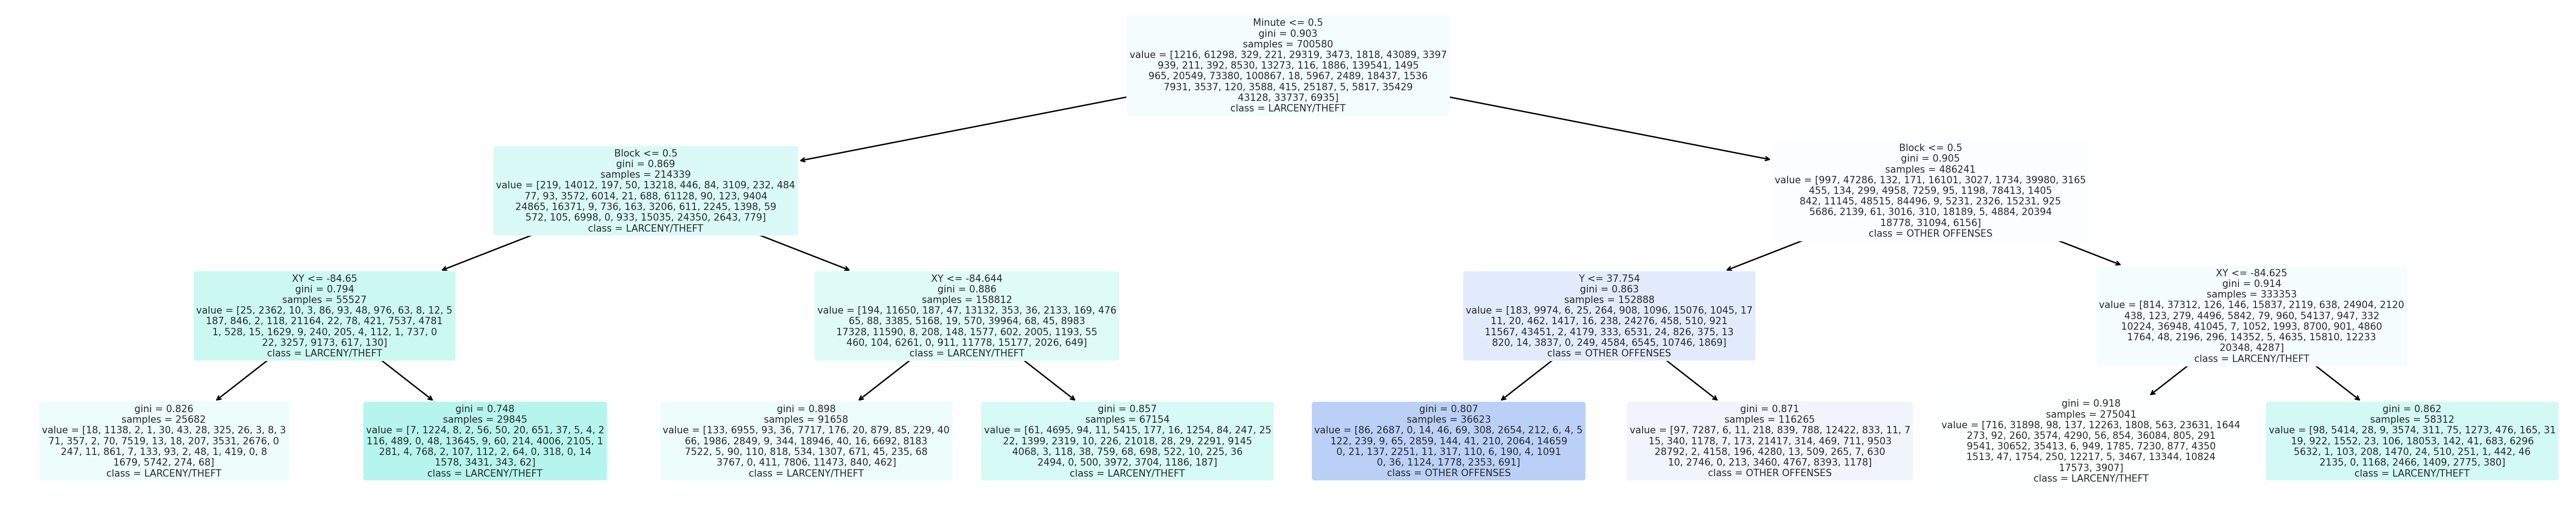

In [77]:
from sklearn import tree
feature_names = ['DayOfWeek',	'PdDistrict',	'Address',	'X',	'Y',	'Day',	'Month',	'Year',	'Hour',	'Minute',	'Second',	'n_days',	'Block',	'ST',	'X_Y',	'XY']
class_names = labelEncoderCategory.inverse_transform(np.arange(39))
fig, axes = plt.subplots(figsize= (100,20))
decisionTreeClassifierTree = tree.plot_tree(decisionTreeClassifierModel,
               feature_names= feature_names,
               class_names= class_names,
               impurity= True,
               rounded= True,
               filled= True,
              #  proportion= True)
               )
for tree in decisionTreeClassifierTree:
    arrow = tree.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
plt.show()

# **Decision tree y_train_predict**

In [78]:
decisionTreeClassifierModelPredict = decisionTreeClassifierModel.predict(X_train)

accuracyscore = accuracy_score(y_train, decisionTreeClassifierModelPredict)
classificationreport = classification_report(y_train, decisionTreeClassifierModelPredict)
precisionscore = precision_score(y_train, decisionTreeClassifierModelPredict, average='macro')
recallscore = recall_score(y_train, decisionTreeClassifierModelPredict, average='macro')
f1score = f1_score(y_train, decisionTreeClassifierModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1216
           1       0.00      0.00      0.00     61298
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       221
           4       0.00      0.00      0.00     29319
           5       0.00      0.00      0.00      3473
           6       0.00      0.00      0.00      1818
           7       0.00      0.00      0.00     43089
           8       0.00      0.00      0.00      3397
           9       0.00      0.00      0.00       939
          10       0.00      0.00      0.00       211
          11       0.00      0.00      0.00       392
          12       0.00      0.00      0.00      8530
          13       0.00      0.00      0.00     13273
          14       0.00      0.00      0.00       116
          15       0.00      0.00

# **Decision tree y_validation_predict**

In [79]:
decisionTreeClassifierModelPredict = decisionTreeClassifierModel.predict(X_validation)

accuracyscore = accuracy_score(y_validation, decisionTreeClassifierModelPredict)
classificationreport = classification_report(y_validation, decisionTreeClassifierModelPredict)
precisionscore = precision_score(y_validation, decisionTreeClassifierModelPredict, average='macro')
recallscore = recall_score(y_validation, decisionTreeClassifierModelPredict, average='macro')
f1score = f1_score(y_validation, decisionTreeClassifierModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.00      0.00      0.00     15517
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00      7281
           5       0.00      0.00      0.00       840
           6       0.00      0.00      0.00       450
           7       0.00      0.00      0.00     10830
           8       0.00      0.00      0.00       880
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        96
          12       0.00      0.00      0.00      2062
          13       0.00      0.00      0.00      3364
          14       0.00      0.00      0.00        30
          15       0.00      0.00

# **Decision tree y_test_predict_proba**

In [80]:
decisionTreeClassifierModelPredict = decisionTreeClassifierModel.predict(X_test)
decisionTreeClassifierModelPredictProba = decisionTreeClassifierModel.predict_proba(X_test)

In [81]:
decisionTreeClassifierModelPredictProba = pd.DataFrame(decisionTreeClassifierModelPredictProba,
                                                   columns=labelEncoderCategory.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), 
                                                   index=test.index)
decisionTreeClassifierModelPredictProba.head(1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.002603,0.115975,0.000356,0.000498,0.044586,0.006574,0.002047,0.085918,0.005977,0.000993,0.000334,0.000945,0.012994,0.015598,0.000204,0.003105,0.131195,0.002927,0.001058,0.034689,0.111445,0.128755,0.000022,0.00345,0.00649,0.026287,0.003189,0.015816,0.005501,0.000171,0.006377,0.000909,0.044419,0.000018,0.012605,0.048516,0.039354,0.063892,0.014205


# **RandomForestClassifier(n_estimators= 1, criterion= 'gini', max_depth= 3, random_state= 42)**

In [91]:
randomForestClassifierModel = RandomForestClassifier(n_estimators= 1, criterion= 'gini', max_depth= 3, random_state= 42)
randomForestClassifierModel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# **Random forest tree**

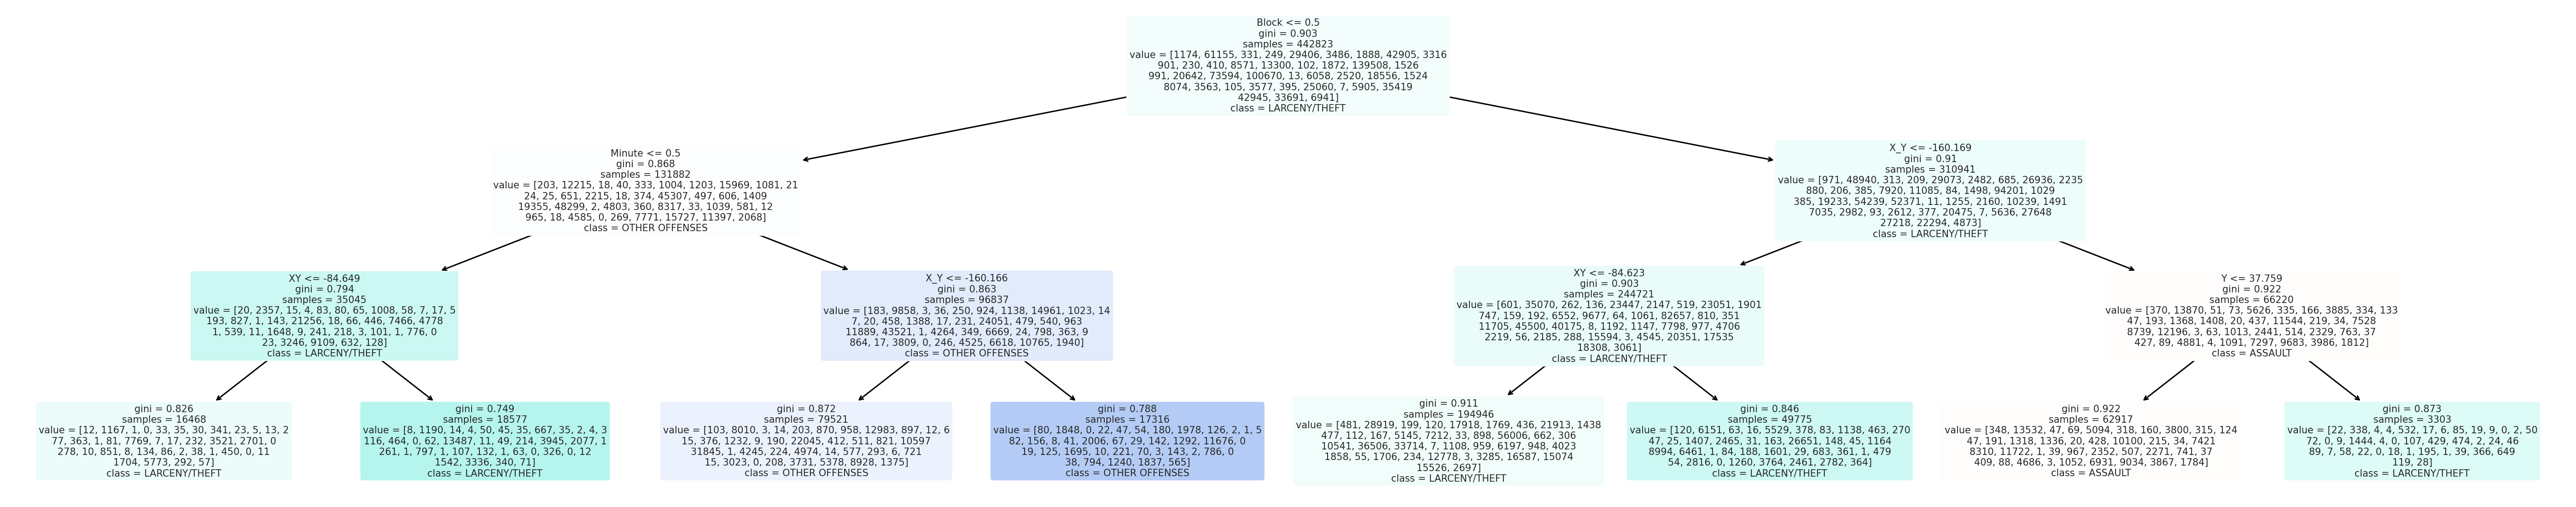

In [92]:
from sklearn import tree
feature_names = ['DayOfWeek',	'PdDistrict',	'Address',	'X',	'Y',	'Day',	'Month',	'Year',	'Hour',	'Minute',	'Second',	'n_days',	'Block',	'ST',	'X_Y',	'XY']
class_names = labelEncoderCategory.inverse_transform(np.arange(39))
fig, axes = plt.subplots(figsize= (100,20))
randomForestClassifierTree = tree.plot_tree(randomForestClassifierModel.estimators_[0],
               feature_names= feature_names,
               class_names= class_names,
               impurity= True,
               rounded= True,
               filled= True,
              #  proportion= True)
               )
for tree in randomForestClassifierTree:
    arrow = tree.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
plt.show()

In [93]:
print("Number of trees in forest: {}".format(len(randomForestClassifierModel.estimators_)))
print("Number of classes: {}".format(randomForestClassifierModel.n_classes_))
print("Number of features: {}".format(randomForestClassifierModel.n_features_))

Number of trees in forest: 1
Number of classes: 39
Number of features: 16


# **Random forest y_train_predict**

In [94]:
randomForestClassifierModelPredict = randomForestClassifierModel.predict(X_train)

accuracyscore = accuracy_score(y_train, randomForestClassifierModelPredict)
classificationreport = classification_report(y_train, randomForestClassifierModelPredict)
precisionscore = precision_score(y_train, randomForestClassifierModelPredict, average='macro')
recallscore = recall_score(y_train, randomForestClassifierModelPredict, average='macro')
f1score = f1_score(y_train, randomForestClassifierModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1216
           1       0.13      0.22      0.17     61298
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       221
           4       0.00      0.00      0.00     29319
           5       0.00      0.00      0.00      3473
           6       0.00      0.00      0.00      1818
           7       0.00      0.00      0.00     43089
           8       0.00      0.00      0.00      3397
           9       0.00      0.00      0.00       939
          10       0.00      0.00      0.00       211
          11       0.00      0.00      0.00       392
          12       0.00      0.00      0.00      8530
          13       0.00      0.00      0.00     13273
          14       0.00      0.00      0.00       116
          15       0.00      0.00

# **Random forest y_validation_predict**

In [95]:
randomForestClassifierModelPredict = randomForestClassifierModel.predict(X_validation)

accuracyscore = accuracy_score(y_validation, randomForestClassifierModelPredict)
classificationreport = classification_report(y_validation, randomForestClassifierModelPredict)
precisionscore = precision_score(y_validation, randomForestClassifierModelPredict, average='macro')
recallscore = recall_score(y_validation, randomForestClassifierModelPredict, average='macro')
f1score = f1_score(y_validation, randomForestClassifierModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.13      0.21      0.16     15517
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00      7281
           5       0.00      0.00      0.00       840
           6       0.00      0.00      0.00       450
           7       0.00      0.00      0.00     10830
           8       0.00      0.00      0.00       880
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        96
          12       0.00      0.00      0.00      2062
          13       0.00      0.00      0.00      3364
          14       0.00      0.00      0.00        30
          15       0.00      0.00

# **Random Forest y_test_predict_proba**

In [96]:
randomForestClassifierModelPredict = randomForestClassifierModel.predict(X_test)
randomForestClassifierModelPredictProba = randomForestClassifierModel.predict_proba(X_test)

In [97]:
randomForestClassifierModelPredictProba = pd.DataFrame(randomForestClassifierModelPredictProba,
                                                   columns=labelEncoderCategory.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), 
                                                   index=test.index)
randomForestClassifierModelPredictProba.head(1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.00349,0.135703,0.000471,0.000692,0.051084,0.003189,0.001605,0.038107,0.003159,0.001244,0.000471,0.001915,0.013217,0.013398,0.000201,0.004292,0.101286,0.002156,0.000341,0.07442,0.083335,0.117551,0.00001,0.000391,0.009697,0.023587,0.005084,0.022774,0.007431,0.000371,0.004102,0.000882,0.046993,0.00003,0.01055,0.069506,0.090595,0.038779,0.01789


# **AdaBoostClassifier(base_estimator= None, n_estimators= 3)**

In [98]:
adaBoostClassifierModel = AdaBoostClassifier(base_estimator= None, n_estimators= 3)
adaBoostClassifierModel.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=3, random_state=None)

# **Adaboost tree**

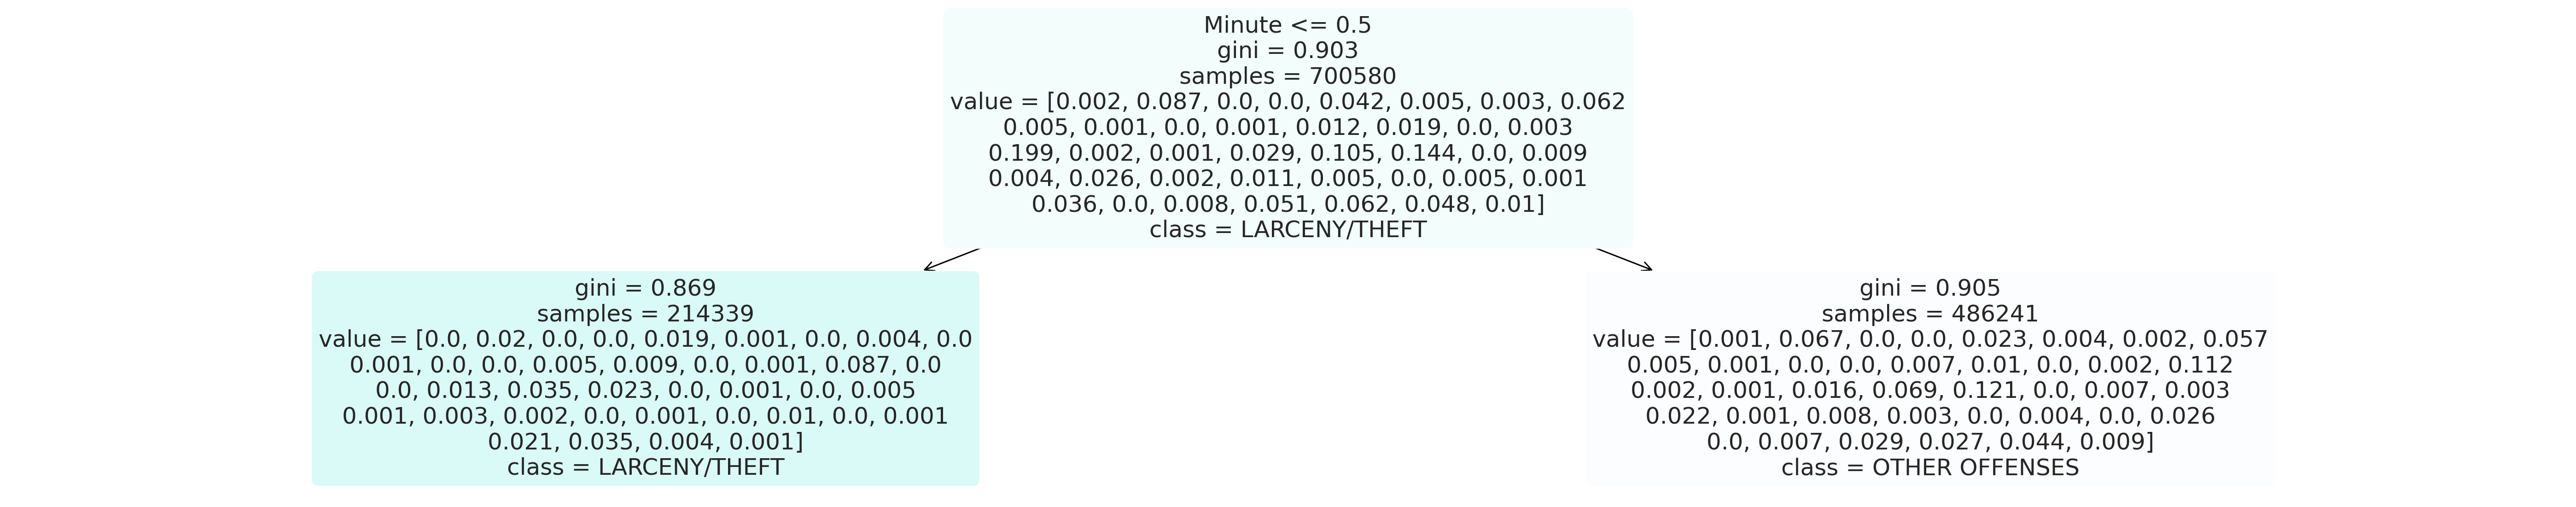

In [100]:
from sklearn import tree
feature_names = ['DayOfWeek',	'PdDistrict',	'Address',	'X',	'Y',	'Day',	'Month',	'Year',	'Hour',	'Minute',	'Second',	'n_days',	'Block',	'ST',	'X_Y',	'XY']
class_names = labelEncoderCategory.inverse_transform(np.arange(39))
fig, axes = plt.subplots(figsize= (100,20))
adaBoostClassifierTree = tree.plot_tree(adaBoostClassifierModel.estimators_[0],
               feature_names= feature_names,
               class_names= class_names,
               impurity= True,
               rounded= True,
               filled= True,
              #  proportion= True)
               )
for tree in adaBoostClassifierTree:
    arrow = tree.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
plt.show()

# **AdaBoost y_train_predict**

In [101]:
adaBoostClassifierModelPredict = adaBoostClassifierModel.predict(X_train)

accuracyscore = accuracy_score(y_train, adaBoostClassifierModelPredict)
classificationreport = classification_report(y_train, adaBoostClassifierModelPredict)
precisionscore = precision_score(y_train, adaBoostClassifierModelPredict, average='macro')
recallscore = recall_score(y_train, adaBoostClassifierModelPredict, average='macro')
f1score = f1_score(y_train, adaBoostClassifierModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1216
           1       0.00      0.00      0.00     61298
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       221
           4       0.00      0.00      0.00     29319
           5       0.00      0.00      0.00      3473
           6       0.00      0.00      0.00      1818
           7       0.00      0.00      0.00     43089
           8       0.00      0.00      0.00      3397
           9       0.00      0.00      0.00       939
          10       0.00      0.00      0.00       211
          11       0.00      0.00      0.00       392
          12       0.00      0.00      0.00      8530
          13       0.00      0.00      0.00     13273
          14       0.00      0.00      0.00       116
          15       0.00      0.00

# **AdaBoost y_validation_predict**

In [102]:
adaBoostClassifierModelPredict = adaBoostClassifierModel.predict(X_validation)

accuracyscore = accuracy_score(y_validation, adaBoostClassifierModelPredict)
classificationreport = classification_report(y_validation, adaBoostClassifierModelPredict)
precisionscore = precision_score(y_validation, adaBoostClassifierModelPredict, average='macro')
recallscore = recall_score(y_validation, adaBoostClassifierModelPredict, average='macro')
f1score = f1_score(y_validation, adaBoostClassifierModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.00      0.00      0.00     15517
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00      7281
           5       0.00      0.00      0.00       840
           6       0.00      0.00      0.00       450
           7       0.00      0.00      0.00     10830
           8       0.00      0.00      0.00       880
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        96
          12       0.00      0.00      0.00      2062
          13       0.00      0.00      0.00      3364
          14       0.00      0.00      0.00        30
          15       0.00      0.00

# **AdaBoost y_test_predict_proba**

In [103]:
adaBoostClassifierModelPredict = adaBoostClassifierModel.predict(X_test)
adaBoostClassifierModelPredictProba = adaBoostClassifierModel.predict_proba(X_test)

In [104]:
adaBoostClassifierModelPredictProba = pd.DataFrame(adaBoostClassifierModelPredictProba,
                                                   columns=labelEncoderCategory.inverse_transform(np.linspace(0, 38, 39, dtype='int16')),
                                                   index=test.index)
adaBoostClassifierModelPredictProba.head(1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.015053,0.05588,0.008483,0.008611,0.042193,0.021931,0.014663,0.049439,0.02164,0.012815,0.008396,0.010922,0.02796,0.030645,0.00697,0.016475,0.06386,0.016503,0.011658,0.03649,0.056047,0.058993,0.003151,0.017718,0.020687,0.034383,0.016326,0.028,0.020342,0.006033,0.022078,0.011233,0.040854,0.001983,0.027988,0.041967,0.038476,0.046223,0.026929


# **GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 1, max_depth= 3, random_state= 42)**

In [105]:
gradientBoostingClassifierModel = GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 1, max_depth= 3, random_state= 42)
gradientBoostingClassifierModel.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# **Gradient boost tree**

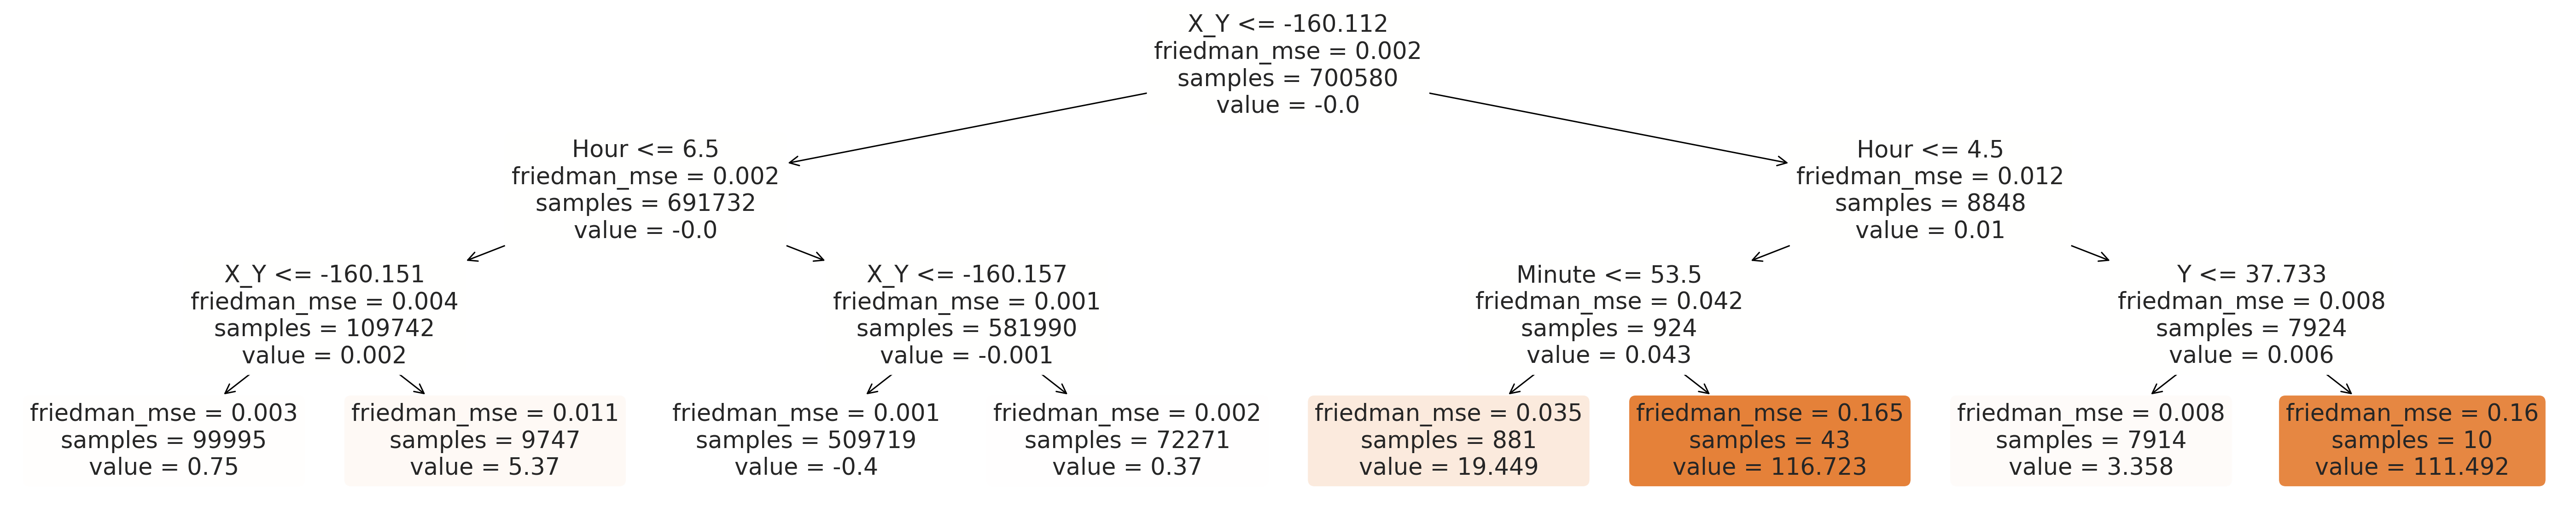

In [106]:
from sklearn import tree
feature_names = ['DayOfWeek',	'PdDistrict',	'Address',	'X',	'Y',	'Day',	'Month',	'Year',	'Hour',	'Minute',	'Second',	'n_days',	'Block',	'ST',	'X_Y',	'XY']
class_names = labelEncoderCategory.inverse_transform(np.arange(39))
fig, axes = plt.subplots(figsize= (100,20))
gradientBoostingClassifierTree = tree.plot_tree(gradientBoostingClassifierModel.estimators_[0, 0],
               feature_names= feature_names,
               class_names= class_names,
               impurity= True,
               rounded= True,
               filled= True,
              #  proportion= True)
               )
for tree in gradientBoostingClassifierTree:
    arrow = tree.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
plt.show()

# **Gradient boost y_train_predict**

In [107]:
gradientBoostingClassifierModelPredict = gradientBoostingClassifierModel.predict(X_train)

accuracyscore = accuracy_score(y_train, gradientBoostingClassifierModelPredict)
classificationreport = classification_report(y_train, gradientBoostingClassifierModelPredict)
precisionscore = precision_score(y_train, gradientBoostingClassifierModelPredict, average='macro')
recallscore = recall_score(y_train, gradientBoostingClassifierModelPredict, average='macro')
f1score = f1_score(y_train, gradientBoostingClassifierModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.21      0.01      0.02      1216
           1       0.00      0.00      0.00     61298
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       221
           4       0.00      0.00      0.00     29319
           5       0.00      0.00      0.00      3473
           6       0.00      0.00      0.00      1818
           7       0.00      0.00      0.00     43089
           8       0.00      0.00      0.00      3397
           9       0.00      0.00      0.00       939
          10       0.00      0.00      0.00       211
          11       0.10      0.02      0.03       392
          12       0.00      0.00      0.00      8530
          13       0.00      0.00      0.00     13273
          14       0.02      0.03      0.02       116
          15       0.00      0.00

# **Gradient boost y_validation_predict**

In [108]:
gradientBoostingClassifierModelPredict = gradientBoostingClassifierModel.predict(X_validation)

accuracyscore = accuracy_score(y_validation, gradientBoostingClassifierModelPredict)
classificationreport = classification_report(y_validation, gradientBoostingClassifierModelPredict)
precisionscore = precision_score(y_validation, gradientBoostingClassifierModelPredict, average='macro')
recallscore = recall_score(y_validation, gradientBoostingClassifierModelPredict, average='macro')
f1score = f1_score(y_validation, gradientBoostingClassifierModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.07      0.00      0.01       296
           1       0.00      0.00      0.00     15517
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00      7281
           5       0.00      0.00      0.00       840
           6       0.00      0.00      0.00       450
           7       0.00      0.00      0.00     10830
           8       0.00      0.00      0.00       880
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        96
          12       0.00      0.00      0.00      2062
          13       0.00      0.00      0.00      3364
          14       0.00      0.00      0.00        30
          15       0.00      0.00

# **Gradient boost y_test_predict_proba**

In [109]:
gradientBoostingClassifierModelPredict = gradientBoostingClassifierModel.predict(X_test)
gradientBoostingClassifierModelPredictProba = gradientBoostingClassifierModel.predict_proba(X_test)

In [110]:
gradientBoostingClassifierModelPredictProba = pd.DataFrame(gradientBoostingClassifierModelPredictProba,
                                                   columns=labelEncoderCategory.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), index=test.index)
gradientBoostingClassifierModelPredictProba.head(1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.001808,0.089923,0.000443,0.000355,0.041617,0.004758,0.003032,0.062854,0.004938,0.001276,0.000293,0.000626,0.011687,0.017817,0.000161,0.002885,0.188224,0.002112,0.001304,0.033165,0.105833,0.142972,0.000024,0.008149,0.005028,0.026258,0.00223,0.011798,0.004964,0.000185,0.005454,0.000608,0.036376,0.000006,0.008481,0.050601,0.059553,0.051984,0.010221


# **XGBClassifier(n_estimators= 1, criterion= 'gini',learning_rate= 0.1, max_depth= 3 ,gamma= 10, reg_lambda= 1, objective= 'multi:softmax', random_state= 42)**

In [111]:
XGBClassifierModel = XGBClassifier(n_estimators= 1, criterion= 'gini',learning_rate= 0.1, max_depth= 3 ,gamma= 10, reg_lambda= 1, 
                                   objective= 'multi:softmax', random_state= 42)
XGBClassifierModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='gini',
              gamma=10, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# **XGBoost tree**

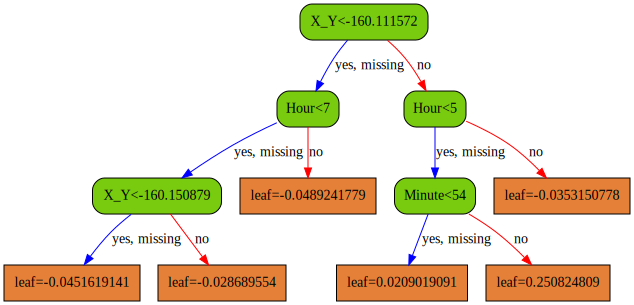

In [112]:
node_params = {
    'shape': 'box',
    'style': 'filled, rounded',
    'fillcolor': '#78cbe'
}
leaf_params = {
    'shape': 'box',
    'style': 'filled',
    'fillcolor': '#e48038'
}
xgb.to_graphviz(XGBClassifierModel, size= "10, 10",
                condition_node_params= node_params,
                leaf_node_params= leaf_params)

# **XGBoost y_train_predict**

In [113]:
XGBClassifierModelPredict = XGBClassifierModel.predict(X_train)

accuracyscore = accuracy_score(y_train, XGBClassifierModelPredict)
classificationreport = classification_report(y_train, XGBClassifierModelPredict)
precisionscore = precision_score(y_train, XGBClassifierModelPredict, average='macro')
recallscore = recall_score(y_train, XGBClassifierModelPredict, average='macro')
f1score = f1_score(y_train, XGBClassifierModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.12      0.00      0.00      1216
           1       0.17      0.07      0.09     61298
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       221
           4       0.00      0.00      0.00     29319
           5       0.00      0.00      0.00      3473
           6       0.00      0.00      0.00      1818
           7       0.29      0.29      0.29     43089
           8       0.00      0.00      0.00      3397
           9       0.00      0.00      0.00       939
          10       0.00      0.00      0.00       211
          11       0.00      0.00      0.00       392
          12       0.04      0.00      0.00      8530
          13       0.10      0.00      0.01     13273
          14       0.00      0.00      0.00       116
          15       0.00      0.00

# **XGBoost y_validation_predict**

In [114]:
XGBClassifierModelPredict = XGBClassifierModel.predict(X_validation)

accuracyscore = accuracy_score(y_validation, XGBClassifierModelPredict)
classificationreport = classification_report(y_validation, XGBClassifierModelPredict)
precisionscore = precision_score(y_validation, XGBClassifierModelPredict, average='macro')
recallscore = recall_score(y_validation, XGBClassifierModelPredict, average='macro')
f1score = f1_score(y_validation, XGBClassifierModelPredict, average='macro')

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('classification report\n{}'.format(classificationreport))
print('accuracy score is {}\n'.format(accuracyscore))
print('precision score is {}\n'.format(precisionscore))
print('recall score is {}\n'.format(recallscore))
print('f1 score is {}'.format(f1score))



The model performance for training set
--------------------------------------
classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.16      0.06      0.09     15517
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00      7281
           5       0.00      0.00      0.00       840
           6       0.00      0.00      0.00       450
           7       0.30      0.29      0.29     10830
           8       0.00      0.00      0.00       880
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        96
          12       0.03      0.00      0.00      2062
          13       0.14      0.00      0.01      3364
          14       0.00      0.00      0.00        30
          15       0.00      0.00

# **XGBoost y_test_predict_proba**

In [115]:
XGBClassifierModelPredict = XGBClassifierModel.predict(X_test)
XGBClassifierModelPredictProba = XGBClassifierModel.predict_proba(X_test)

In [116]:
XGBClassifierModelPredictProba = pd.DataFrame(XGBClassifierModelPredictProba,
                                                   columns=labelEncoderCategory.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), 
                                              index=test.index)
XGBClassifierModelPredictProba.head(1)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.024386,0.030128,0.024351,0.024343,0.026251,0.024542,0.024653,0.028107,0.0246,0.024356,0.024342,0.0244,0.024654,0.024647,0.024336,0.024459,0.029747,0.024473,0.024362,0.027659,0.030386,0.031582,0.024329,0.024419,0.025121,0.025563,0.024504,0.025101,0.024522,0.024336,0.024744,0.024355,0.026292,0.024328,0.024809,0.026835,0.026339,0.028685,0.024956


  # **Sources:**

  1.   https://www.kaggle.com/c/sf-crime
  2.   https://docs.streamlit.io/en/stable/api.html
  3.   https://scikit-learn.org/stable/modules/classes.html
  4.   https://www.kaggle.com/yannisp/sf-crime-analysis-prediction
  5.   https://www.kaggle.com/sjun4530/sf-crime-classification-hyper/
  6.   https://xgboost.readthedocs.io/en/latest/python/python_api.html
  7.   https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
  8.   https://www.youtube.com/playlist?list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF
  9.   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
  10.  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
  11.  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
  12.  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
  13.  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html